In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import numpy as np
from tqdm.auto import tqdm
import torch
from cases.isic_exp.dataset import (
    get_df,
    get_transforms,
    MelanomaDataset,
    MelanomaDatasetFx,
)
from cases.isic_exp.models import (
    Effnet_Melanoma,
    Resnest_Melanoma,
    Seresnext_Melanoma,
    ModelFx,
)
from cases.isic_exp.train import get_trans
import matplotlib.pyplot as plt
import cv_exp.gradient as gradient
import cv_exp.cam as cam


ModelClass = Effnet_Melanoma
device = torch.device("mps")

df_valids = []
val_datasets = []
val_dataloaders = []
for fold in range(1):
    val_dataset_fx = MelanomaDatasetFx(fold=fold)
    val_dataset = val_dataset_fx.val_dataset
    args = val_dataset_fx.args
    val_datasets.append(val_dataset)
    val_dataloaders.append(
        torch.utils.data.DataLoader(
            val_dataset, batch_size=args.batch_size, num_workers=args.num_workers
        )
    )

In [6]:
models = []
for fold in range(1):
    model = ModelFx(fold=fold)
    models.append(model.model.to(device))

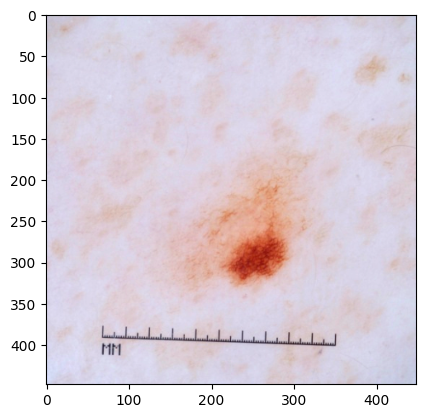

tensor(7)


In [7]:
from cv_exp.utils.data_utils import min_max_norm

i = 600
image = val_datasets[0][i][0]
target = val_datasets[0][i][1]
plt.imshow(min_max_norm(image.numpy().transpose(1, 2, 0)))
plt.show()
images = torch.stack([image.to(device)])
targets = torch.stack([target.to(device)])
print(target)

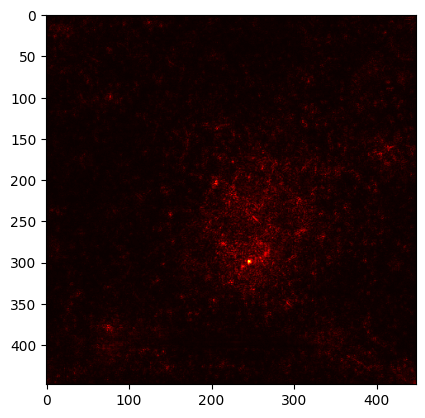

In [8]:
from cv_exp.gradient import vanilla_gradient

unary = vanilla_gradient(models[0], images, targets, loss=True)
unary = min_max_norm(unary.cpu().numpy())[0]
from matplotlib import cm

un = unary
cmap = getattr(cm, "hot")
plt.imshow(un, cmap=cmap)
plt.show()

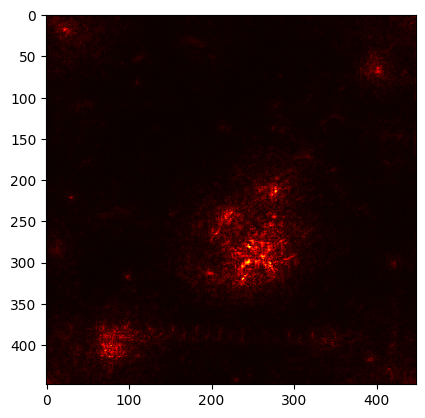

In [9]:
unary = gradient.smooth_grad(models[0], images, targets, loss=True)
unary = min_max_norm(unary.cpu().numpy())[0]
from matplotlib import cm

un = unary
cmap = getattr(cm, "hot")
plt.imshow(un, cmap=cmap)
plt.show()

In [10]:
ran_idx = []
melanoma_dataset_fx = MelanomaDatasetFx(fold=fold)
val_dataset = melanoma_dataset_fx.val_dataset
classes_map = melanoma_dataset_fx.classes_map
class_label = melanoma_dataset_fx.class_label

[2259, 191, 2636, 2615, 2905]


Proposed Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

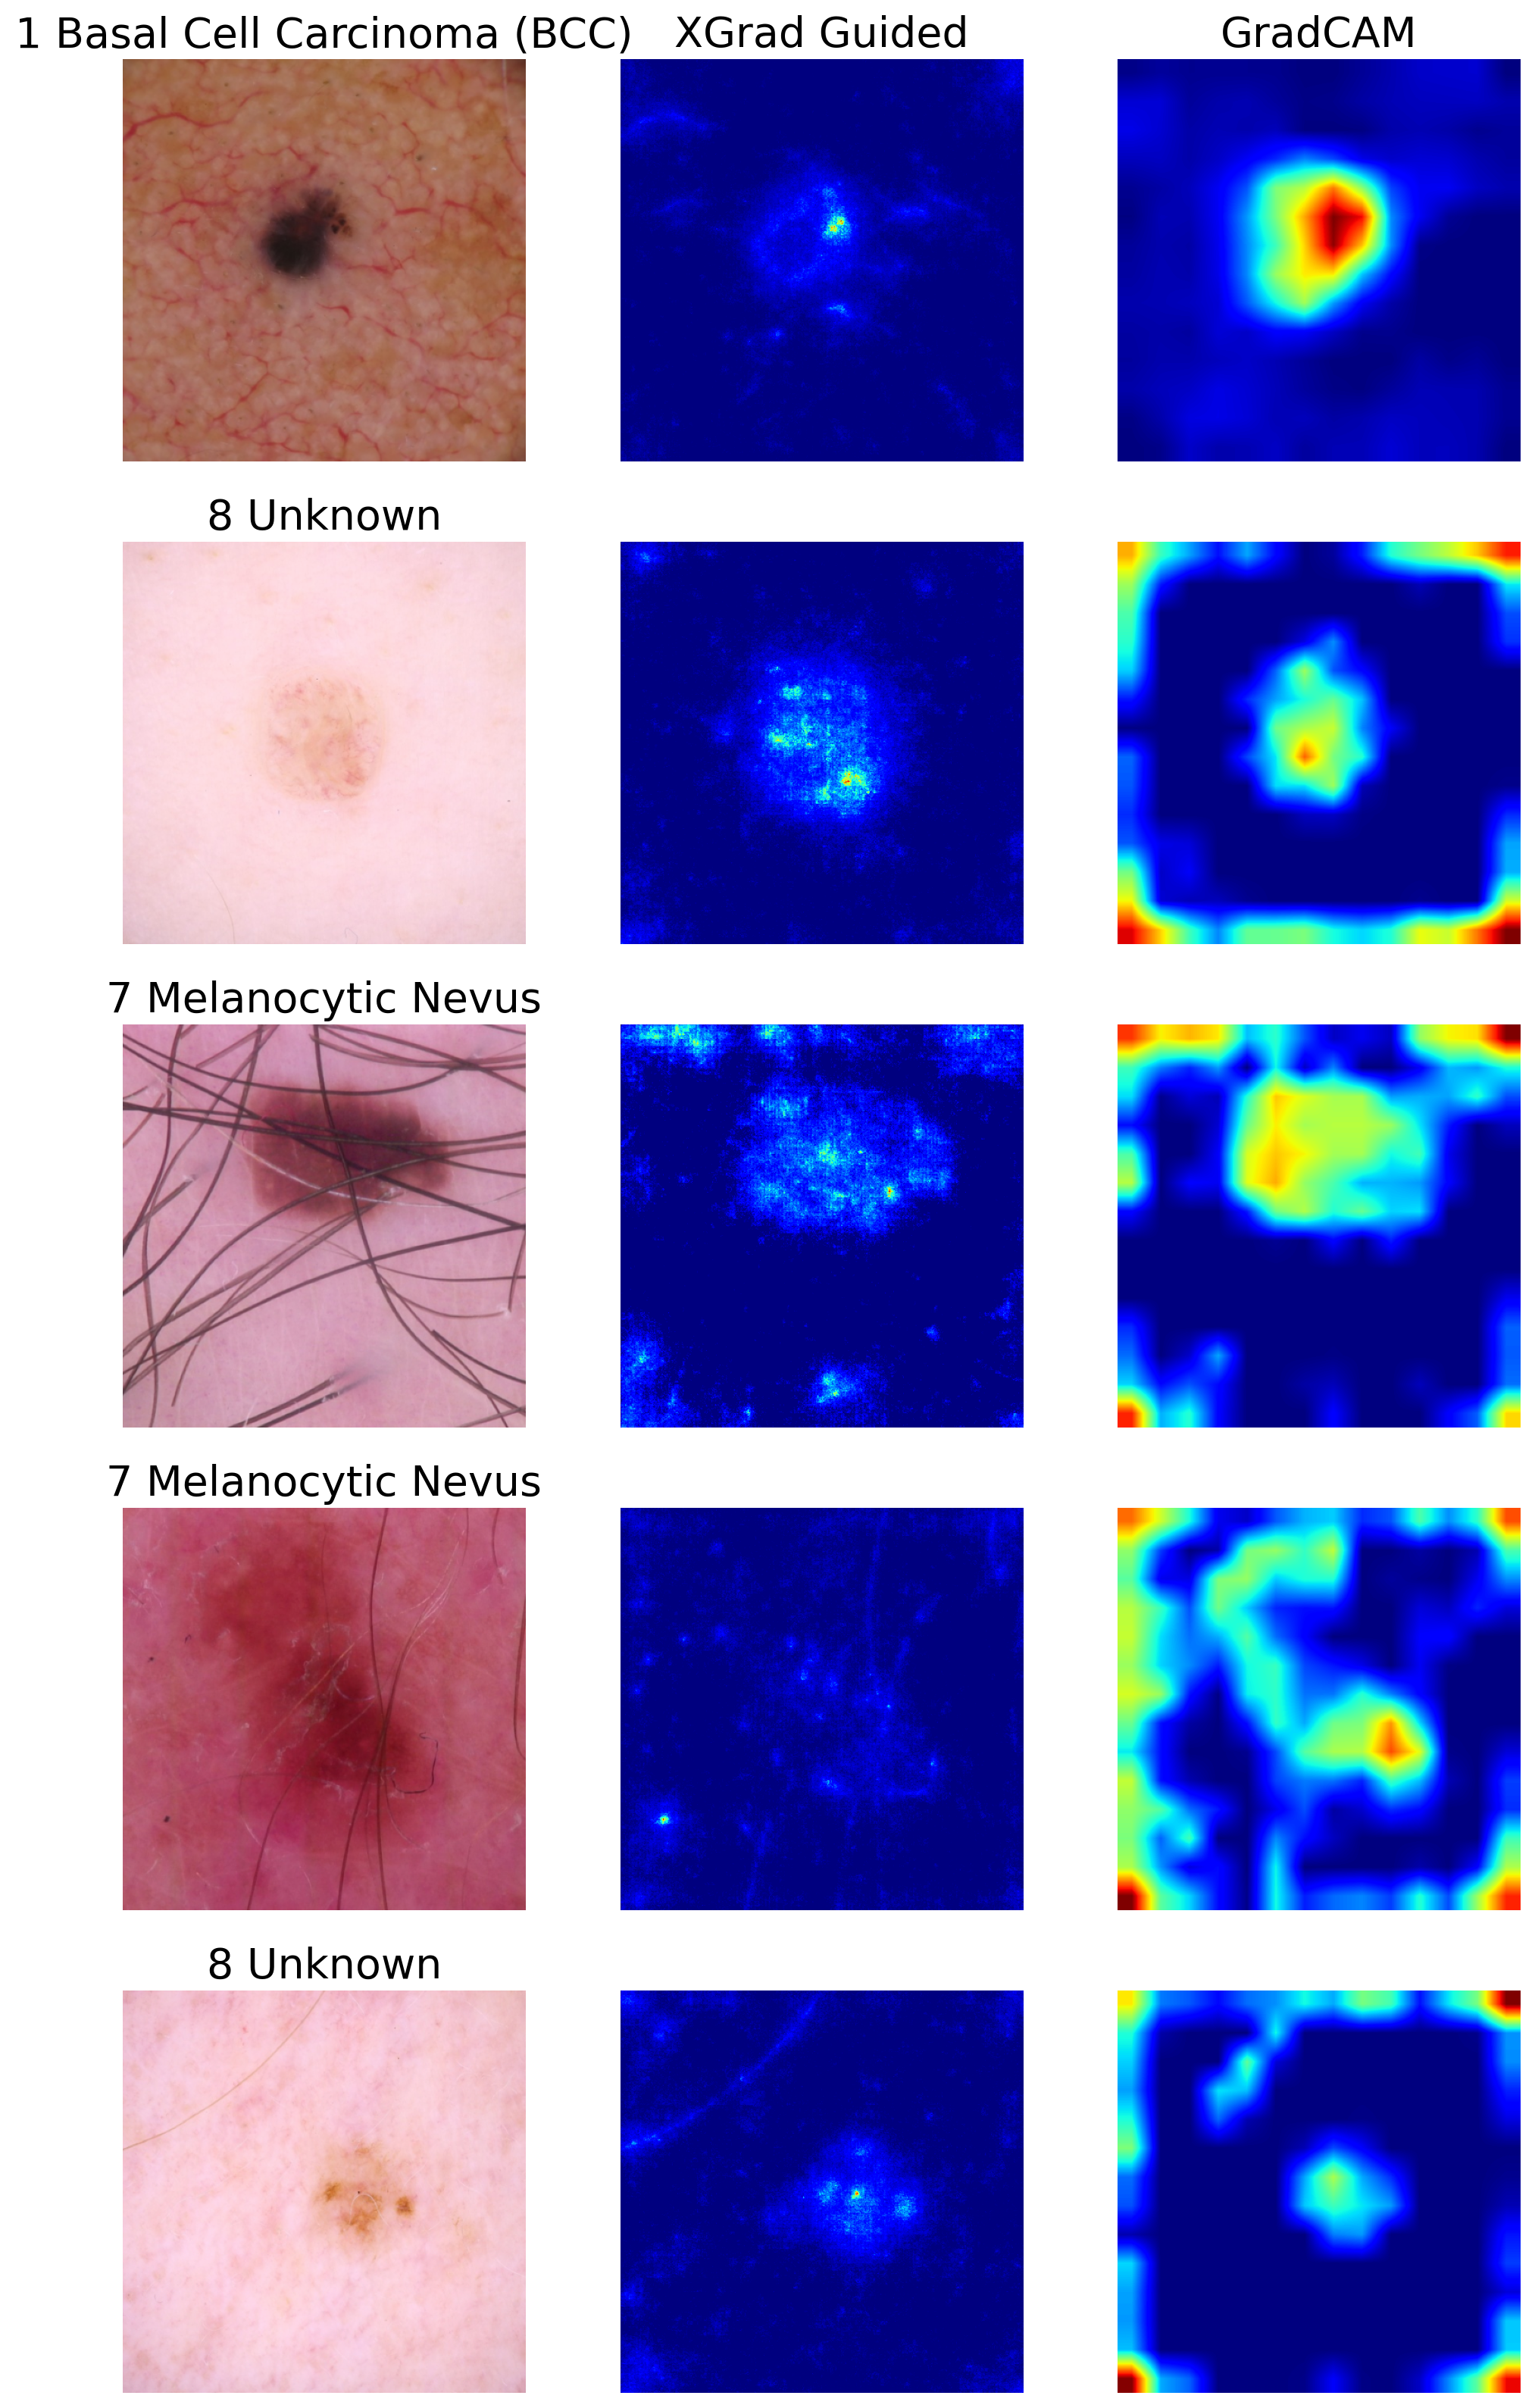

[(1, 'XGrad Guided'), (2, 'GradCAM')]


{'Prob: M3': ['RCAP2',
  {'Mean': <function cv_exp.eval._eval.aggregate_different_eval_rs.<locals>.<lambda>(d)>,
   'Sum': <function cv_exp.eval._eval.aggregate_different_eval_rs.<locals>.<lambda>(d)>,
   'Original': <function cv_exp.eval._eval.aggregate_different_eval_rs.<locals>.<lambda>(d)>,
   'Count': <function cv_exp.eval._eval.aggregate_different_eval_rs.<locals>.<lambda>(d)>},
  [['XGrad Guided', 0.72903264], ['GradCAM', 0.85800636]],
  'Mean',
  False,
  [['XGrad Guided', 0.0], ['GradCAM', 1.0]]]}

In [11]:
import cv_exp
import cv_exp.eval as eval
from cv_exp.utils import plotting_utils
import json, random

n = 5  # @param {type:"number"}
keep = "no"  # @param ["yes", "no"]
# keep = "yes" #@param ["yes", "no"]
specified = ""  # @param {type:"string"}
# specified = "[1317]" #@param {type:"string"}
# specified = "[1317, 2796]" #@param {type:"string"}
num_samples = 10  # @param {type:"number"}
std_spread = 0.15  # @param {type:"number"}
th = 0.4  # @param {type:"number"}

if len(ran_idx) == 0 or keep == "no":
    idxs = [i for i in range(len(val_dataset))]
    random.shuffle(idxs)
    ran_idx = idxs[:n]

if specified != "":
    ran_idx = json.loads(specified)
    n = len(ran_idx)

settings = {
    # 'Vanilla': [gradient.vanilla_gradient, {}],
    # f'GuidedBP x {num_samples}': [gradient.guided_back_propagation, {'aggregation': 'sum',  'iteration': 1},
    # False, True],
    # f'Neg GuidedBP 1': [gradient.guided_back_propagation, {
    #     'direction': 'negative'
    # }, False, True],
    # f'Pos GuidedBP 1': [gradient.guided_back_propagation, {
    #     'direction': 'positive'
    # }, False, True],
    # f'Abs GuidedBP 1': [gradient.guided_back_propagation, {
    #     'direction': 'abs'
    # }, False, True],
    # 'IntGrad': [gradient.integrated_gradients, {
    #     'steps': 3,
    #     'trials': 4,
    # }, False, True],
    # '30 BlurIG 20r': [gradient.blur_ig, {
    # }, False, True],
    # 'Abs BlurIG': [gradient.blur_ig, {
    #     'ifabs': True,
    # }, False, True],
    # 'BlurIG+': [gradient.blur_ig, {
    #     'direction': 'positive',
    # }, False, True],
    # 'BlurIG-': [gradient.blur_ig, {
    #     'direction': 'negative',
    # }, False, True],
    # 'GuidedIG': [gradient.guided_ig, {
    #     'num_samples': num_samples,
    # }, False, True],
    # 'Abs GuidedIG': [gradient.guided_ig, {
    #     'num_samples': num_samples,
    #     'ifabs': True
    # }, False, True],
    # 'SmoothGrad': [gradient.smooth_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    # }, False, True],
    # 'SmoothGrad-RV': [gradient.reversed_smooth_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    # }, False, True],
    # 'AbsSmoothGrad': [gradient.smooth_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    #     'ifabs': True,
    # }, False, True],
    # 'squared smooth': [gradient.smooth_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    #     'ifsquare': True,
    # }, False, True],
    # 'vargrad': [gradient.var_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    # }, False, True],
    # 'XGrad-Var': [gradient.guided_absolute_grad, {
    #     'num_samples': num_samples,
    #     "aggregation": 'variance',
    # }, False, True],
    # 'No Abs XGrad Mean': [gradient.guided_absolute_grad, {
    #     'ifabs': False,
    #     'num_samples': num_samples,
    # }, False, True],
    # 'XGrad Mean': [gradient.guided_absolute_grad, {
    #     'num_samples': num_samples,
    # }, False, True],
    "XGrad Guided": [
        gradient.guided_absolute_grad,
        {"num_samples": num_samples, "aggregation": "guided", "th": 0.7},
        False,
        True,
    ],
    "GradCAM": [
        cam.grad_cam,
        {
            "target_layers": [getattr(models[0].enet.blocks, "6")],
            # 'eigen_smooth': True
        },
        False,
        True,
    ],
    # 'var-square': [gradient.var_grad, {
    #     'num_samples': num_samples,
    #     'std_spread': std_spread,
    #     'ifsquare': True,
    # }, False, True],
}

# for p in [0.95, 0.85,0.75,0.65,0.55, 0.45, 0.35, 0.25, 0.15, 0]:
#     settings[f'XGrad Guided {p}'] = [gradient.guided_absolute_grad, {
#         'num_samples': num_samples,
#         'aggregation': 'guided',
#         'th': p
#     }, False, True]
print(ran_idx)
unary_rs = eval.evaluation_demo(
    # ModelFx(-1, device=device).model, val_datasets[0], None, device, settings, ran_idx, classes_map, class_label,
    models[0],
    val_datasets[0],
    None,
    device,
    settings,
    ran_idx,
    classes_map,
    class_label,
    random_seed=42,
    # stop=0.25, steps=0.25,
    stop=0.2,
    steps=0.2,
    ifquantus=False,
    debug=False,
    # ifquantus=False, debug=True
)
plotting_utils.plot_eval_rs(*unary_rs[-2:], sort_key="RCAP2")
# why the method works for the im-balanced dataset

In [ ]:
# for sequence, id in enumerate(ran_idx):
#     cv_exp.plotting_utils.save_pic('isic', id, sequence, unary_rs, settings)